In [1]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [2]:
print(tf.__version__)

2.10.0


In [3]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [6]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .82)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [7]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [8]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler, SMOTE




0    649
1     63
Name: binding, dtype: int64
0    73
1    15
Name: binding, dtype: int64


In [9]:
sampler = RandomOverSampler(sampling_strategy=.15)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    649
1     97
Name: binding, dtype: int64
0    73
1    15
Name: binding, dtype: int64


In [10]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [11]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
features = select_k_best_features(training_split,train_result,.30,vectorizer_best.get_feature_names_out())

In [12]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [13]:
smote = SMOTE(random_state=42)
x, y = smote.fit_resample(training_split, train_result)
training_split = x
train_result = y
print(training_split.shape)
print(test_split.shape)

(1298, 24921)
(88, 24921)


In [14]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [15]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [16]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [17]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(4 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [18]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( 5 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [82]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')

        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if current_train_recall > .45:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('Recall TRAINING: ', current_train_recall)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [83]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.025)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [102]:
ensemble_size = 12
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        print(" =========== iteration ===========>:", i )
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 60
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.0075 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [103]:
# plt.plot(initial_weight)
boosting(initial_weight)

 =========== iteration ===========>: 0
bfore traning:  49.9075500770416
Epoch 1/60


2022-11-12 19:13:43.839227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1658 - tp: 1854.0000 - fp: 164.0000 - tn: 3087.0000 - fn: 1385.0000 - precision: 0.9187 - recall: 0.5724

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.705345273350108
Recall TRAINING:  0.5723989009857178
93/93 [==============================] - 3s 19ms/step - loss: 1.1658 - tp: 1854.0000 - fp: 164.0000 - tn: 3087.0000 - fn: 1385.0000 - precision: 0.9187 - recall: 0.5724



****** Early Stopping *******
41/41 [==============================] - 0s 3ms/step


2022-11-12 19:13:46.406131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6935166994106091
0.7596302003081664
error_rate: 0.00018518474552529462
0.999999999999962
 =========== iteration ===========>: 1
bfore traning:  52.003081664098616
Epoch 1/60


2022-11-12 19:13:47.740959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1581 - tp: 3099.0000 - fp: 1659.0000 - tn: 1456.0000 - fn: 276.0000 - precision: 0.6513 - recall: 0.9182

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.762080406868686
Recall TRAINING:  0.918222188949585
93/93 [==============================] - 3s 19ms/step - loss: 1.1581 - tp: 3099.0000 - fp: 1659.0000 - tn: 1456.0000 - fn: 276.0000 - precision: 0.6513 - recall: 0.9182



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-12 19:13:50.244439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7410491257285596
0.7604006163328197
error_rate: 0.00019607272646584773
0.9999999999999901
 =========== iteration ===========>: 2
bfore traning:  51.15562403697997
Epoch 1/60


2022-11-12 19:13:51.714547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1545 - tp: 2379.0000 - fp: 1814.0000 - tn: 1356.0000 - fn: 941.0000 - precision: 0.5674 - recall: 0.7166

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.633302260150512
Recall TRAINING:  0.716566264629364
93/93 [==============================] - 3s 19ms/step - loss: 1.1545 - tp: 2379.0000 - fp: 1814.0000 - tn: 1356.0000 - fn: 941.0000 - precision: 0.5674 - recall: 0.7166



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-12 19:13:54.216675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6992930940728657
0.573959938366718
error_rate: 0.00031647792619005896
1.00000000000001
 =========== iteration ===========>: 3
bfore traning:  49.93836671802773
Epoch 1/60


2022-11-12 19:13:55.535047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1646 - tp: 1511.0000 - fp: 168.0000 - tn: 3081.0000 - fn: 1730.0000 - precision: 0.8999 - recall: 0.4662

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6142276563078346
Recall TRAINING:  0.4662141501903534
93/93 [==============================] - 3s 19ms/step - loss: 1.1646 - tp: 1511.0000 - fp: 168.0000 - tn: 3081.0000 - fn: 1730.0000 - precision: 0.8999 - recall: 0.4662



****** Early Stopping *******
29/41 [====================>.........] - ETA: 0s

2022-11-12 19:13:57.967319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.6128016789087094
0.7157164869029276
error_rate: 0.000232606397724113
0.9999999999999923
 =========== iteration ===========>: 4
bfore traning:  50.955315870570104
Epoch 1/60


2022-11-12 19:13:59.298537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1567 - tp: 2820.0000 - fp: 2585.0000 - tn: 598.0000 - fn: 487.0000 - precision: 0.5217 - recall: 0.8527

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6473829255163273
Recall TRAINING:  0.8527366518974304
93/93 [==============================] - 3s 20ms/step - loss: 1.1567 - tp: 2820.0000 - fp: 2585.0000 - tn: 598.0000 - fn: 487.0000 - precision: 0.5217 - recall: 0.8527



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-12 19:14:01.848087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6697626418988648
0.5069337442218799
error_rate: 0.00037084026098841
0.9999999999999998
 =========== iteration ===========>: 5
bfore traning:  48.166409861325114
Epoch 1/60


2022-11-12 19:14:03.154079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1619 - tp: 1711.0000 - fp: 491.0000 - tn: 2873.0000 - fn: 1415.0000 - precision: 0.7770 - recall: 0.5473

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.642267290800453
Recall TRAINING:  0.5473448634147644
93/93 [==============================] - 3s 19ms/step - loss: 1.1619 - tp: 1711.0000 - fp: 491.0000 - tn: 2873.0000 - fn: 1415.0000 - precision: 0.7770 - recall: 0.5473



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-12 19:14:05.591788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7392120075046903
0.785824345146379
error_rate: 0.00019187827015280378
0.9999999999999857
 =========== iteration ===========>: 6
bfore traning:  50.693374422187986
Epoch 1/60


2022-11-12 19:14:06.934699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1547 - tp: 2329.0000 - fp: 501.0000 - tn: 2699.0000 - fn: 961.0000 - precision: 0.8230 - recall: 0.7079

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7611111620245894
Recall TRAINING:  0.7079027891159058
93/93 [==============================] - 3s 21ms/step - loss: 1.1547 - tp: 2329.0000 - fp: 501.0000 - tn: 2699.0000 - fn: 961.0000 - precision: 0.8230 - recall: 0.7079



****** Early Stopping *******
28/41 [===================>..........] - ETA: 0s

2022-11-12 19:14:09.538487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.911062906724512
0.9052388289676425
error_rate: 8.029932993985344e-05
0.9999999999999766
 =========== iteration ===========>: 7
bfore traning:  49.815100154083204
Epoch 1/60


2022-11-12 19:14:10.873189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1584 - tp: 2215.0000 - fp: 426.0000 - tn: 2831.0000 - fn: 1018.0000 - precision: 0.8387 - recall: 0.6851

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7541709435380768
Recall TRAINING:  0.6851221919059753
93/93 [==============================] - 3s 20ms/step - loss: 1.1584 - tp: 2215.0000 - fp: 426.0000 - tn: 2831.0000 - fn: 1018.0000 - precision: 0.8387 - recall: 0.6851



****** Early Stopping *******
41/41 [==============================] - 0s 4ms/step


2022-11-12 19:14:13.466024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6531027466937944
0.7372881355932204
error_rate: 0.00023858636119133275
0.9999999999999784
 =========== iteration ===========>: 8
bfore traning:  50.38520801232666
Epoch 1/60


2022-11-12 19:14:14.800790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 3s 20ms/step - loss: 1.1617 - tp: 1234.0000 - fp: 123.0000 - tn: 3097.0000 - fn: 2036.0000 - precision: 0.9094 - recall: 0.3774
Epoch 2/60
93/93 [==============================] - 1s 13ms/step - loss: 0.3324 - tp: 1396.0000 - fp: 135.0000 - tn: 3085.0000 - fn: 1874.0000 - precision: 0.9118 - recall: 0.4269
Epoch 3/60
93/93 [==============================] - 1s 14ms/step - loss: 0.3330 - tp: 1272.0000 - fp: 144.0000 - tn: 3076.0000 - fn: 1998.0000 - precision: 0.8983 - recall: 0.3890
Epoch 4/60
93/93 [==============================] - 1s 14ms/step - loss: 0.3333 - tp: 1295.0000 - fp: 146.0000 - tn: 3074.0000 - fn: 1975.0000 - precision: 0.8987 - recall: 0.3960
Epoch 5/60
93/93 [==============================] - 1s 13ms/step - loss: 0.3334 - tp: 1319.0000 - fp: 150.0000 - tn: 3070.0000 - fn: 1951.0000 - precision: 0.8979 - recall: 0.4034
Epoch 6/60
93/93 [==============================] - 1s 14ms/step - loss: 0.3348 - tp: 1442.0000 - fp: 158.0000 

2022-11-12 19:14:24.921797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.725883476599809
0.7788906009244992
error_rate: 0.0002286688989907301
1.0000000000000007
 =========== iteration ===========>: 9
bfore traning:  53.035439137134055
Epoch 1/60


2022-11-12 19:14:26.290843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1562 - tp: 3307.0000 - fp: 2902.0000 - tn: 146.0000 - fn: 135.0000 - precision: 0.5326 - recall: 0.9608

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6853176152153034
Recall TRAINING:  0.9607785940170288
93/93 [==============================] - 3s 22ms/step - loss: 1.1562 - tp: 3307.0000 - fp: 2902.0000 - tn: 146.0000 - fn: 135.0000 - precision: 0.5326 - recall: 0.9608



****** Early Stopping *******
32/41 [======================>.......] - ETA: 0s

2022-11-12 19:14:29.005989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.6666666666666666
0.5
error_rate: 0.0003660344181886835
1.0000000000000087
 =========== iteration ===========>: 10
bfore traning:  48.87519260400616
Epoch 1/60


2022-11-12 19:14:30.325191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1574 - tp: 1923.0000 - fp: 569.0000 - tn: 2749.0000 - fn: 1249.0000 - precision: 0.7717 - recall: 0.6062

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6790254195164732
Recall TRAINING:  0.6062421202659607
93/93 [==============================] - 3s 22ms/step - loss: 1.1574 - tp: 1923.0000 - fp: 569.0000 - tn: 2749.0000 - fn: 1249.0000 - precision: 0.7717 - recall: 0.6062



****** Early Stopping *******
31/41 [=====================>........] - ETA: 0s

2022-11-12 19:14:33.192996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.7100478468899522
0.7665639445300462
error_rate: 0.0002464076277095449
0.999999999999996
 =========== iteration ===========>: 11
bfore traning:  51.20184899845916
Epoch 1/60


2022-11-12 19:14:34.512981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1585 - tp: 1798.0000 - fp: 179.0000 - tn: 2988.0000 - fn: 1525.0000 - precision: 0.9095 - recall: 0.5411

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6784905886530482
Recall TRAINING:  0.5410773754119873
93/93 [==============================] - 3s 24ms/step - loss: 1.1585 - tp: 1798.0000 - fp: 179.0000 - tn: 2988.0000 - fn: 1525.0000 - precision: 0.9095 - recall: 0.5411



****** Early Stopping *******
31/41 [=====================>........] - ETA: 0s

2022-11-12 19:14:37.574985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.9076175040518639
0.9121725731895224
error_rate: 7.112799905792916e-05
0.9999999999999871


In [104]:
alphas

[0.06445478553618192,
 0.06402621616656469,
 0.06043455400703746,
 0.06274447634655335,
 0.05924526181807634,
 0.0641884312495894,
 0.07072251734214283,
 0.06255405447690128,
 0.0628725507116723,
 0.05934312816594182,
 0.062312076991346894,
 0.0716321877739604]

In [105]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [106]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


In [107]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    return score

In [108]:
f1_test = []
for i in range(1,13):
    data = some_pred(test_split, i)
    ans = majority(data)
    f1_test.append(getf1(test_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
3/3 [==============================] - 0s 33ms/step
*********: 0
3/3 [==============================] - 0s 11ms/step


2022-11-12 19:14:46.614773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
3/3 [==============================] - 0s 18ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 7ms/step


2022-11-12 19:14:46.823797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 19ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 8ms/step


2022-11-12 19:14:47.055078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 11ms/step
*********: 3
3/3 [==============================] - 0s 27ms/step
*********: 0
3/3 [==============================] - 0s 6ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step


2022-11-12 19:14:47.355239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 4ms/step
*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 23ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 6ms/step


2022-11-12 19:14:47.683225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 5ms/step
*********: 3
3/3 [==============================] - 0s 9ms/step
*********: 4
3/3 [==============================] - 0s 8ms/step
*********: 5
3/3 [==============================] - 0s 20ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step


2022-11-12 19:14:48.060118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 5ms/step
*********: 3
3/3 [==============================] - 0s 5ms/step
*********: 4
3/3 [==============================] - 0s 9ms/step
*********: 5
3/3 [==============================] - 0s 7ms/step
*********: 6
3/3 [==============================] - 0s 18ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
1/3 [=========>....................] - ETA: 0s

2022-11-12 19:14:48.494210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 4ms/step
*********: 3
3/3 [==============================] - 0s 6ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 6ms/step
*********: 7
3/3 [==============================] - 0s 25ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step


2022-11-12 19:14:50.376492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 4ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 23ms/step
*********: 0
3/3 [==============================] - 0s 8ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step


2022-11-12 19:14:50.910742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 4ms/step
*********: 5
3/3 [==============================] - 0s 7ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 6ms/step
*********: 8
3/3 [==============================] - 0s 12ms/step
*********: 9
3/3 [==============================] - 0s 26ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step


2022-11-12 19:14:51.452367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 8ms/step
*********: 3
3/3 [==============================] - 0s 4ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 8ms/step
*********: 7
3/3 [==============================] - 0s 3ms/step
*********: 8
3/3 [==============================] - 0s 4ms/step
*********: 9
3/3 [==============================] - 0s 7ms/step
*********: 10
3/3 [==============================] - 0s 30ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 4ms/step


2022-11-12 19:14:52.022296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
3/3 [==============================] - 0s 4ms/step
*********: 3
3/3 [==============================] - 0s 15ms/step
*********: 4
3/3 [==============================] - 0s 8ms/step
*********: 5
3/3 [==============================] - 0s 9ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step
*********: 7
3/3 [==============================] - 0s 8ms/step
*********: 8
3/3 [==============================] - 0s 4ms/step
*********: 9
3/3 [==============================] - 0s 6ms/step
*********: 10
3/3 [==============================] - 0s 6ms/step
*********: 11
3/3 [==============================] - 0s 20ms/step


2022-11-12 19:14:52.746695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


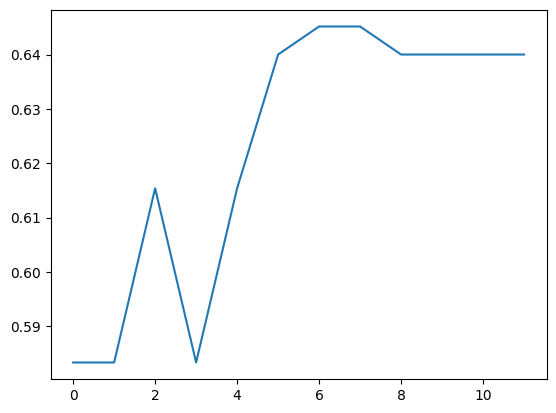

In [109]:
plt.plot(f1_test)

*********: 0
3/3 [==============================] - 0s 6ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 3ms/step
*********: 5
3/3 [==============================] - 0s 3ms/step
*********: 6
3/3 [==============================] - 0s 3ms/step


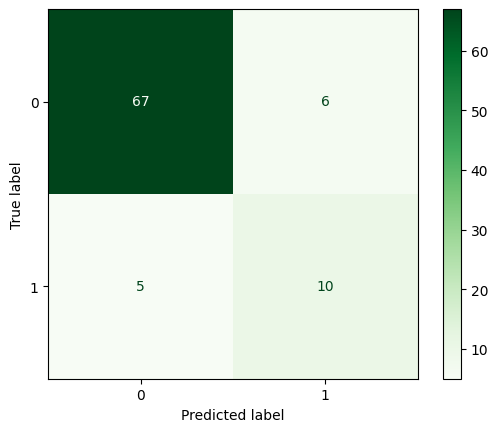

In [114]:
data = some_pred(test_split, 7)
ans = majority(data)
ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')
# plt.plot(f1_test)

In [110]:
f1_train = []
for i in range(1,13):
    data = some_pred(training_split, i)
    ans = majority(data)
    f1_train.append(getf1(train_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
41/41 [==============================] - 0s 4ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 4ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 4ms/step
*********: 2
41/41 [==============================] - 0s 4ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 4
41/41 [==============================] - 0s 4ms/step
*********:

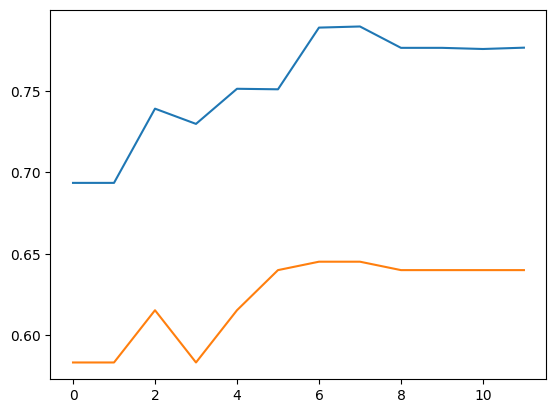

In [111]:
plt.plot(f1_train)
plt.plot(f1_test)

*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 4
41/41 [==============================] - 0s 3ms/step
*********: 5
41/41 [==============================] - 0s 3ms/step
*********: 6
41/41 [==============================] - 0s 3ms/step


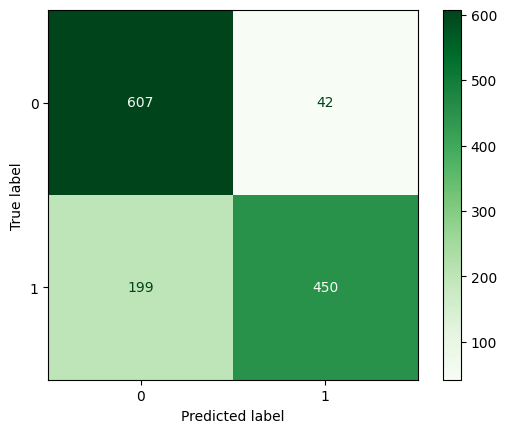

In [113]:
data = some_pred(training_split, 7)
ans = majority(data)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [115]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 7))

*********: 0
11/11 [==============================] - 0s 9ms/step
*********: 1
11/11 [==============================] - 0s 7ms/step
*********: 2
11/11 [==============================] - 0s 6ms/step
*********: 3
11/11 [==============================] - 0s 5ms/step
*********: 4
11/11 [==============================] - 0s 6ms/step
*********: 5
11/11 [==============================] - 0s 7ms/step
*********: 6
11/11 [==============================] - 0s 6ms/step


In [117]:
len(predicted_data)


350

In [118]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()